# Analysing data (GRIB)

In this notebook we will demonstrate how to:
* find locations of extreme values from GRIB data
* compute and plot a time series extracted from a point
* mask values that are not of interest
* compute wind speed
* compute and plot a vertical cross section
* compute and plot a vertical profile

We will use **Metview** to do all of this.

The data we will work with in this notebook is related to storm Joachim from December 2011. The 10 metre windgust forecast was retrieved from MARS for a few steps on a low resolution grid to provide input for the exercises. This is stored in file "joachim_wind_gust.grib". Further data, stored in "joachim_uv.grib", gives wind components on various pressure levels.

## Exploring the surface wind gusts

### Loading the data and finding the extreme values

In [1]:
import metview as mv

Read the data from GRIB file into a Metview Fieldset:

In [2]:
wg = mv.read("joachim_wind_gust.grib")
print(wg)
print(len(wg))

5


The data is a **Fieldset** with 5 fields. Let's inspect the contents with a few GRIB keys:

In [3]:
mv.grib_get(wg, ['shortName', 'dataDate', 'dataTime',
                 'stepRange', 'validityDate', 'validityTime']) 

[['10fg6', '20111215', '1200', '6-12', '20111216', '0'],
 ['10fg6', '20111215', '1200', '12-18', '20111216', '600'],
 ['10fg6', '20111215', '1200', '18-24', '20111216', '1200'],
 ['10fg6', '20111215', '1200', '24-30', '20111216', '1800'],
 ['10fg6', '20111215', '1200', '30-36', '20111217', '0']]

First let's check the minimum and maximum values over all the fields:

In [4]:
print(mv.minvalue(wg), mv.maxvalue(wg))

0.9916973114013672 39.74169731140137


Now, the maximum values for each field - iterate over the fieldset:

In [5]:
all_maxes = [mv.maxvalue(f) for f in wg]
all_maxes

[39.74169731140137,
 37.20536518096924,
 37.363698959350586,
 37.525485038757324,
 37.46825695037842]

So we can see immediately that the largest value occurs in the first field. Let's restrict our operations to this first field:

In [6]:
wg0 = wg[0]
max0 = all_maxes[0]

Find the locations where the value equals the maximum:

In [7]:
max_location = mv.find(wg0, max0)
max_location

[[47.0, -3.5]]

### Extracting a time series

Obtain a time series of values at this location (one value from each field):

In [8]:
vals_for_point = mv.nearest_gridpoint(wg, max_location[0])
times = mv.valid_date(wg)
for tv in zip(times, vals_for_point):
    print(tv)

(datetime.datetime(2011, 12, 16, 0, 0), 39.74169731140137)
(datetime.datetime(2011, 12, 16, 6, 0), 36.70536518096924)
(datetime.datetime(2011, 12, 16, 12, 0), 25.863698959350586)
(datetime.datetime(2011, 12, 16, 18, 0), 32.525485038757324)
(datetime.datetime(2011, 12, 17, 0, 0), 27.468256950378418)


Let's make a simple plot from the data - we could use matplotlib, but Metview can also give us a nice time series curve:

In [9]:
haxis = mv.maxis(
    axis_type = "date",
    axis_date_type = "hours",
    axis_hours_label = "on",
    axis_hours_label_height = 0.4,
    axis_years_label_height = 0.4,
    axis_months_label_height = 0.4,
    axis_days_label_height = 0.4
    )

ts_view = mv.cartesianview(
    x_automatic = "on",
    x_axis_type = "date",
    y_automatic = "on",
    horizontal_axis = haxis
    )
 
curve_wg = mv.input_visualiser(
    input_x_type        = "date",
    input_date_x_values = times,
    input_y_values      = vals_for_point)

visdef = mv.mgraph(graph_line_thickness=3)

Finally we set the plotting target to the **Jupyter notebook** (we only have to do it once in a notebook) and generate the plot:

In [10]:
mv.setoutput('jupyter')

The order of parameters to the plot() command matters: view, data, visual definitions. There can be multiple sets of data and visual definitions in the same plot() command.

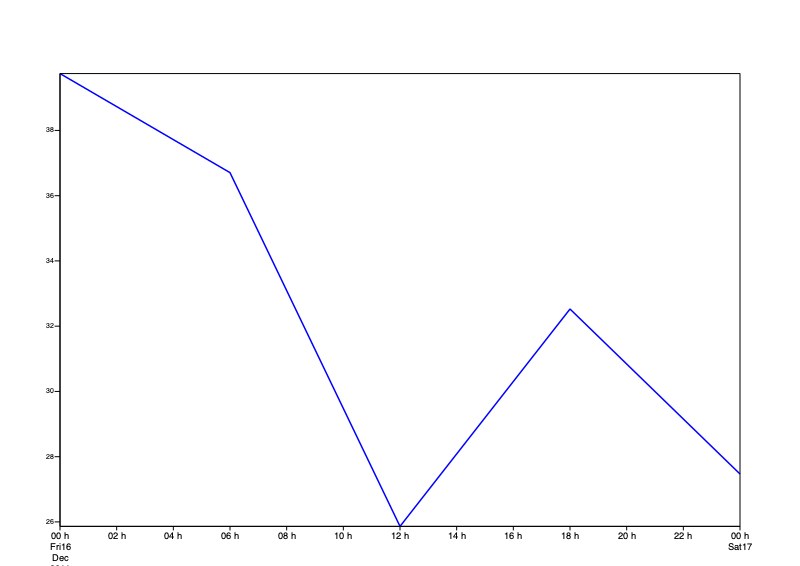

In [11]:
mv.plot(ts_view, curve_wg, visdef)

### Finding a range of extreme values

Find the locations where the value is within 95% of the maximum by supplying a range of values:

In [12]:
mv.find(wg0, [max0*0.95, max0])

[[48.5, -5.0], [48.5, -4.5], [47.0, -7.0], [47.0, -3.5], [47.0, -3.0]]

If we want to work with these points in Metview, the easiest way is to use the gfind() function to return a **Geopoints** variable:

In [13]:
max_points = mv.gfind(wg0, max0, max0*0.05)
print(len(max_points), 'points')
print('first point:')
max_points[0]

5 points
first point:


{'latitude': 48.5,
 'longitude': -5.0,
 'height': 0.0,
 'date': 20111216.0,
 'time': 0.0,
 'value': 38.7417,
 'value_missing': 0.0,
 'value2': 0.0,
 'value2_missing': 0.0}

Compute a simple bounding box for these points:

In [14]:
north = mv.latitudes(max_points).max() + 2
south = mv.latitudes(max_points).min() - 2
east = mv.longitudes(max_points).max() + 2
west = mv.longitudes(max_points).min() - 2
[north, south, east, west]

[50.5, 45.0, -1.0, -9.0]

Plot the points on a map using this bounding box:

In [15]:
view = mv.geoview(
    map_area_definition = "corners",
    area                = [south, west, north, east]
    )

In [16]:
coloured_markers = mv.msymb(
    legend                                 = "on",
    symbol_type                            = "marker",
    symbol_table_mode                      = "advanced",
    symbol_advanced_table_max_level_colour = "red",
    symbol_advanced_table_min_level_colour = "RGB(1, 0.8, 0.8)",
    symbol_advanced_table_height_list      = 0.8
    )

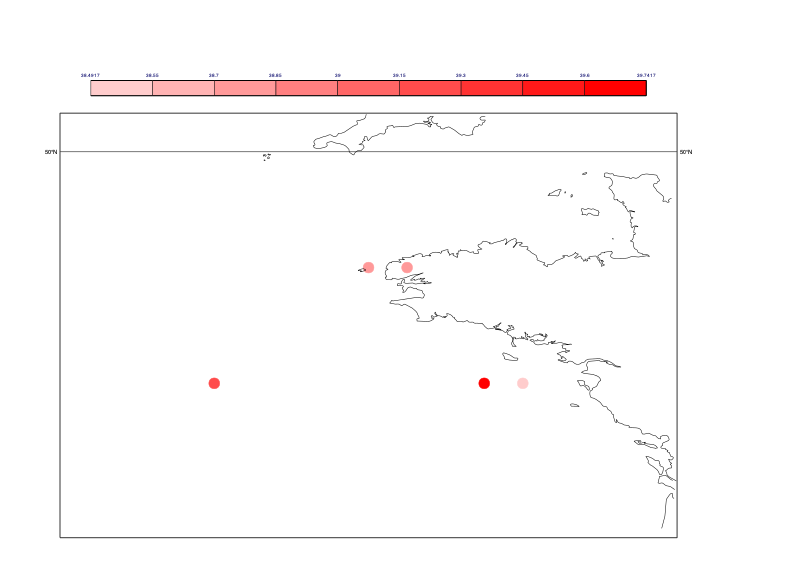

In [17]:
mv.plot(view, max_points, coloured_markers)

### Using Fieldset operations to preserve only the extreme values

Alternative way to obtain the largest values - use **Fieldset** operations:

In [18]:
# compute field of 1s and 0s according to test
largest_mask = wg0 > (max0*0.85)

# convert 0s into missing values
largest_mask = mv.bitmap(largest_mask, 0)

# copy the pattern of missing values to wg0
masked_wg0 = mv.bitmap(wg0, largest_mask)

The result has **missing values** where the original values were below our threshold. In terms of actual data storage, if we were to write this into a GRIB file, it would be much smaller than the original GRIB file because GRIB is very efficient at (not) storing missing values. Let's plot the result with grid point markers:

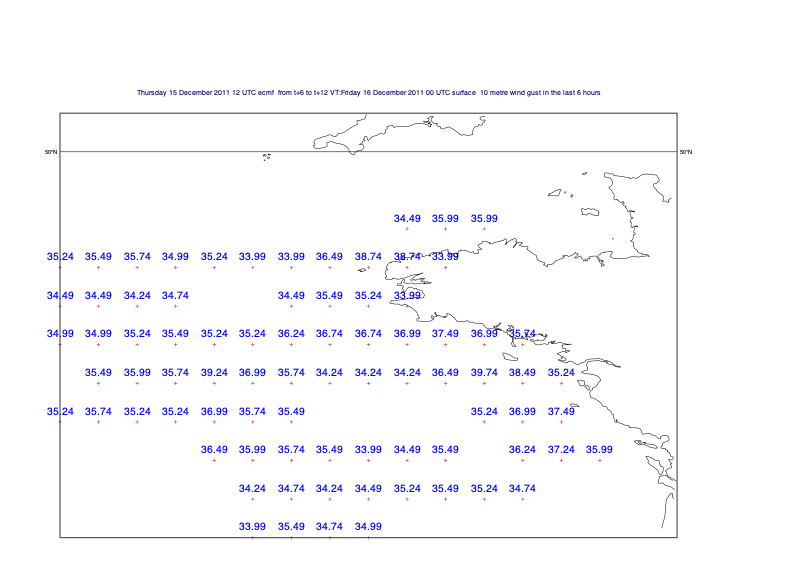

In [19]:
gridvals_1x1 = mv.mcont(
    contour                          = "off",
    contour_grid_value_plot          = "on",
    contour_grid_value_plot_type     = "both",
    contour_grid_value_format        = "(F4.2)",
    contour_grid_value_height        = 0.45,
    grib_scaling_of_retrieved_fields = "off"
    )

mv.plot(view, masked_wg0, gridvals_1x1)

## Exploring the atmosphere

### Retrieve U/V wind component data on multiple pressure levels

To explore further into the atmosphere, we will need appropriate data. We can either retrieve from MARS or read from the supplied GRIB file, which was originally taken from MARS and then subsampled and downgraded a little in order to make the file smaller:

In [20]:
use_mars = False

In [21]:
if use_mars:
    uv = mv.retrieve(
        type     = "fc",
        levelist = [1000,925,850,700,500,400,300,250,200,150,100],
        param    = ["u","v"],
        date     = 20111215,
        step     = 12,
        area     = [25,-60,75,60],
        grid     = [0.25,0.25]
        )
else:
    uv = mv.read("joachim_uv.grib")

In [22]:
mv.grib_get(uv, ['shortName','level'])

[['u', '1000'],
 ['v', '1000'],
 ['u', '925'],
 ['v', '925'],
 ['u', '850'],
 ['v', '850'],
 ['u', '700'],
 ['v', '700'],
 ['u', '500'],
 ['v', '500'],
 ['u', '400'],
 ['v', '400'],
 ['u', '300'],
 ['v', '300'],
 ['u', '250'],
 ['v', '250'],
 ['u', '200'],
 ['v', '200'],
 ['u', '150'],
 ['v', '150'],
 ['u', '100'],
 ['v', '100']]

### Compute wind speed

Extract the U and V components into different Fieldsets, each will have 11 fields:

In [29]:
u = mv.read(data = uv, param = "u")
v = mv.read(data = uv, param = "v")

Compute the **wind speed** directly on the Fieldsets, giving us a single Fieldset containing 11 fields of wind speed:

In [30]:
spd = mv.sqrt(u*u + v*v)

Change the paramId and extract 500hPa level for plotting (not stricly necessary, but it lets us use the default ecCharts style, which requires a correct paramId):

In [31]:
spd = mv.grib_set_long(spd, ['paramId', 10])
spd500 = mv.read(data = spd, levelist = 500)

Plot the field into a view that covers the data area:

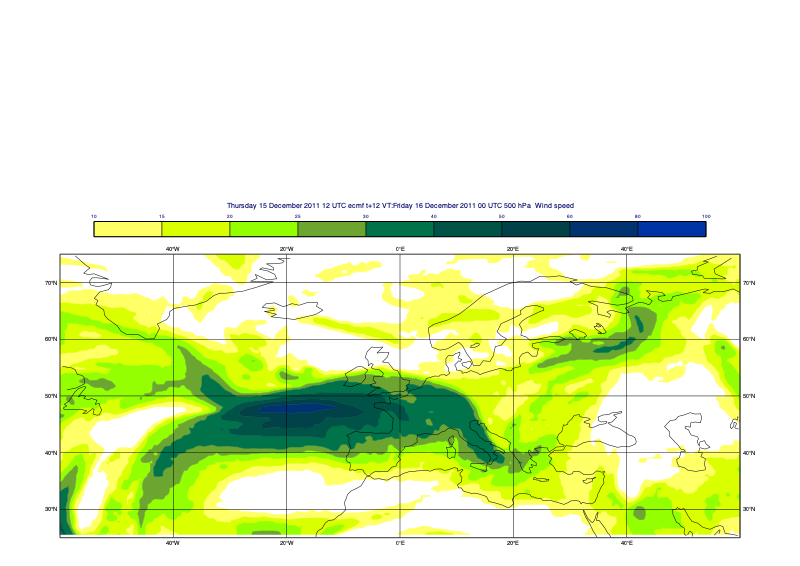

In [32]:
view = mv.geoview(
    map_area_definition = "corners",
    area                = [25,-60,75,60]
    )
mv.plot(view, spd500, mv.mcont(contour_automatic_setting='ecmwf', legend='on'))

### Compute and plot a vertical cross section

Define a line along an area of interest and plot it onto the map:

In [27]:
line = [43.3,-36.0,54.4,13.1] # S, W, N, E

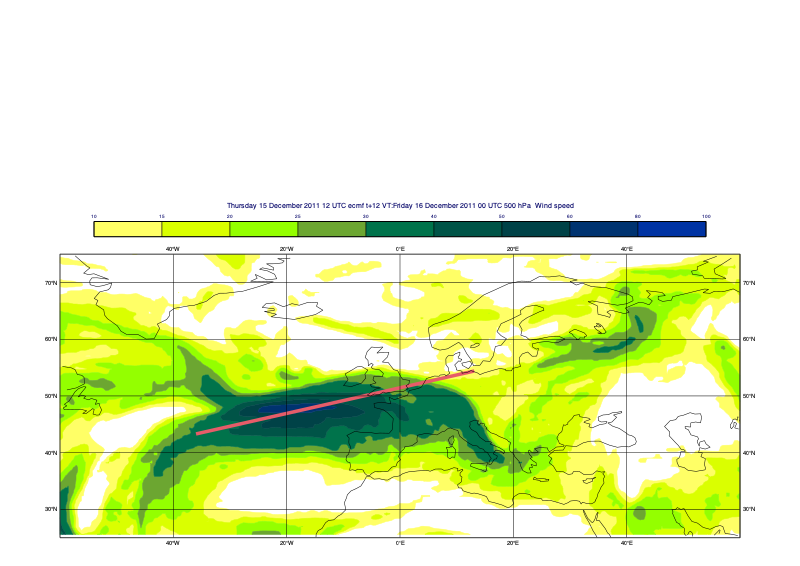

In [28]:
line_graph = mv.mgraph(
    graph_type         = "curve",
    graph_line_colour  = "pink",
    graph_line_thickness = 7
)

mv.plot(
    view,
    spd500,
    mv.mcont(contour_automatic_setting='ecmwf', legend='on'),
    mv.mvl_geoline(*line,1),line_graph
)

Use this line to define a cross section view:

In [33]:
xs_view = mv.mxsectview(
    bottom_level = 1000.0,
    top_level    = 100,
    line         = line
    )

Create a colour scale to plot the data with:

In [34]:
xs_shade = mv.mcont(
    legend                         = "on",
    contour_line_style             = "dash",
    contour_line_colour            = "charcoal",
    contour_highlight              = "off",
    contour_level_count            = 20,
    contour_label                  = "off",
    contour_shade                  = "on",
    contour_shade_method           = "area_fill",
    contour_shade_max_level_colour = "red",
    contour_shade_min_level_colour = "blue",
    contour_shade_colour_direction = "clockwise"
    )

Into the view, plot the data using the given Contouring definition (note the order):

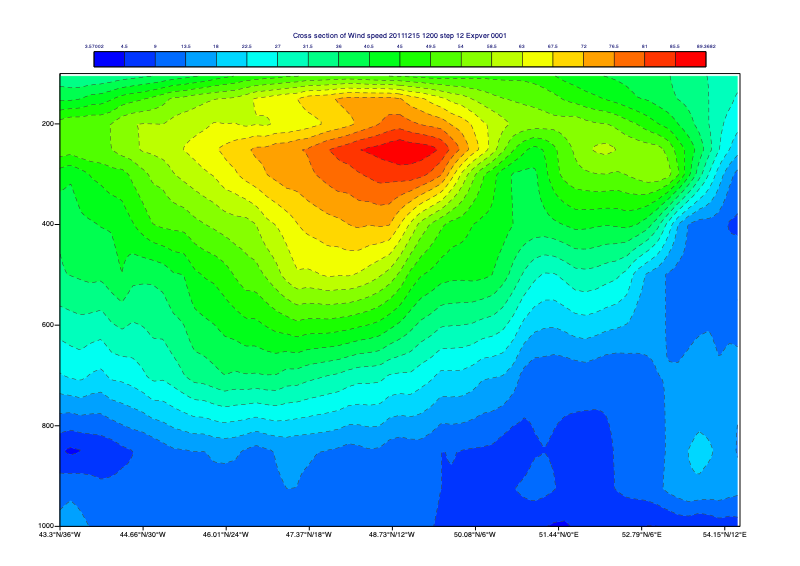

In [35]:
mv.plot(xs_view, spd, xs_shade)

We can also obtain the computed cross section data as a netCDF, which we can write to disk as "mv.write('my_xs.nc', xs_data)" :

In [36]:
xs_data = mv.mcross_sect(
    data = spd,
    line = line
    )
print(xs_data)

### Compute and plot a vertical profile

Define a **vertical profile view** and plotting attributes:

In [37]:
vp_view = mv.mvertprofview(
    point        = [47.0,-3.5],
    bottom_level = 1000,
    top_level    = 100
    )

graph_plotting = mv.mgraph(
    graph_line_colour    = "red",
    graph_line_thickness = 3
    )

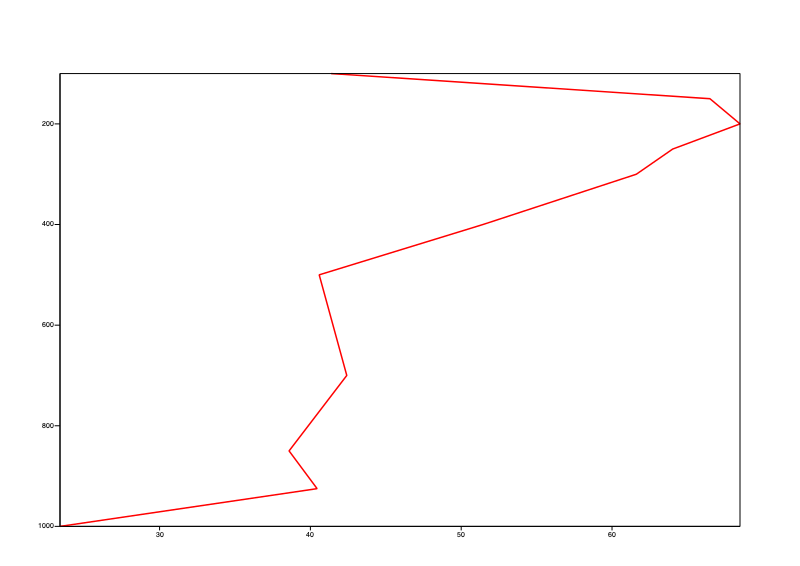

In [38]:
mv.plot(vp_view, spd, graph_plotting)

# Additional resources

- [Introductory Metview training course](https://confluence.ecmwf.int/display/METV/Data+analysis+and+visualisation+using+Metview)
- [Metview's Python interface](https://confluence.ecmwf.int/display/METV/Metview%27s+Python+Interface)
- [Gallery](https://confluence.ecmwf.int/display/METV/Gallery)
- [Function list](https://confluence.ecmwf.int/display/METV/List+of+Operators+and+Functions)